### COVID-19 Open Research Dataset Challenge (CORD-19)
An AI challenge with AI2, CZI, MSR, Georgetown, NIH & The White House

![https://iamcheated.indianmoney.com/uploads/NewsImages/News_IMAGE-20200306120354.jpg](https://iamcheated.indianmoney.com/uploads/NewsImages/News_IMAGE-20200306120354.jpg)

## Dataset Description
In response to the COVID-19 pandemic, the White House and a coalition of leading research groups have prepared the COVID-19 Open Research Dataset (CORD-19). CORD-19 is a resource of over 47,000 scholarly articles, including over 36,000 with full text, about COVID-19, SARS-CoV-2, and related coronaviruses. This freely available dataset is provided to the global research community to apply recent advances in natural language processing and other AI techniques to generate new insights in support of the ongoing fight against this infectious disease. There is a growing urgency for these approaches because of the rapid acceleration in new coronavirus literature, making it difficult for the medical research community to keep up

## Call to Action

We are issuing a call to action to the world's artificial intelligence experts to develop text and data mining tools that can help the medical community develop answers to high priority scientific questions. The CORD-19 dataset represents the most extensive machine-readable coronavirus literature collection available for data mining to date. This allows the worldwide AI research community the opportunity to apply text and data mining approaches to find answers to questions within, and connect insights across, this content in support of the ongoing COVID-19 response efforts worldwide. There is a growing urgency for these approaches because of the rapid increase in coronavirus literature, making it difficult for the medical community to keep up.

A list of our initial key questions can be found under the Tasks [https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks](https://www.kaggle.com/allen-institute-for-ai/CORD-19-research-challenge/tasks) section of this dataset. These key scientific questions are drawn from the NASEM’s SCIED (National Academies of Sciences, Engineering, and Medicine’s Standing Committee on Emerging Infectious Diseases and 21st Century Health Threats) research topics and the World Health Organization’s R&D Blueprint for COVID-19.

Many of these questions are suitable for text mining, and we encourage researchers to develop text mining tools to provide insights on these questions.

We are maintaining a summary of the community's contributions. For guidance on how to make your contributions useful, we're maintaining a forum thread with the feedback we're getting from the medical and health policy communities.


## Import required libraries

In [1]:
import numpy as np
import torch
import tensorflow
import pandas as pd
import os
import json
import time
import glob
import re
import sys
import collections
from nltk import flatten
import dask
from dask import delayed,compute
import dask.dataframe as dd
from dask.multiprocessing import get
from tqdm._tqdm_notebook import tqdm_notebook
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm
tqdm_notebook.pandas()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:17: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.*` instead of `tqdm._tqdm_notebook.*`


## Extract JSON files to CSV

In [2]:
sys.path.insert(0, "../")

root_path = '/kaggle/input/CORD-19-research-challenge'

corona_features = {"doc_id": [None], "source": [None], "title": [None],
                  "abstract": [None], "text_body": [None]}
corona_df = pd.DataFrame.from_dict(corona_features)

json_filenames = glob.glob(f'{root_path}/**/*.json', recursive=True)

In [3]:
def return_corona_df(json_filenames, df, source):
    
    for file_name in tqdm(json_filenames[20000:50000]):

        row = {}

        with open(file_name) as json_data:
            data = json.load(json_data)

            doc_id = data['paper_id']
            row['doc_id'] = doc_id
            row['title'] = data['metadata']['title']

            # Now need all of abstract. Put it all in 
            # a list then use str.join() to split it
            # into paragraphs. 
            try:
                abstract_list = [abst['text'] for abst in data['abstract']]
                abstract = "\n ".join(abstract_list)

                row['abstract'] = abstract
            except:
                row['abstract'] = np.nan
            # And lastly the body of the text. 
            body_list = [bt['text'] for bt in data['body_text']]
            body = "\n ".join(body_list)
            
            row['text_body'] = body
            
            # Now just add to the dataframe. 
            
            if source == 'b':
                row['source'] = "BIORXIV"
            elif source == "c":
                row['source'] = "COMMON_USE_SUB"
            elif source == "n":
                row['source'] = "NON_COMMON_USE"
            elif source == "p":
                row['source'] = "PMC_CUSTOM_LICENSE"
            
            df = df.append(row, ignore_index=True)
            
            
    return df
    
corona_df = return_corona_df(json_filenames,corona_df, 'b')

100%|██████████| 30000/30000 [06:21<00:00, 78.65it/s] 


In [4]:
corona_df.dropna(subset=['text_body'],inplace=True)

In [5]:
corona_df.head()

,doc_id,source,title,abstract,text_body
1,PMC5697887,BIORXIV,Spatiotemporal dynamics of HSV genome nuclear ...,None,Virtually all DNA virus classes including herp...
2,PMC5652715,BIORXIV,Bid-deficient fish delay grass carp reovirus (...,None,The grass carp (Ctenopharyngodon idellus) is o...
3,PMC6053424,BIORXIV,A novel European H5N8 influenza A virus has in...,None,"In nature, sixteen different hemagglutinin (HA..."
4,PMC6206136,BIORXIV,Evaluation of a recombination-resistant corona...,None,Emerging and re-emerging zoonotic viral diseas...
5,PMC3103500,BIORXIV,"SARS-CoV 9b Protein Diffuses into Nucleus, Und...",None,Severe acute respiratory syndrome (SARS) was a...


## EDA

In [98]:
#Install scispcy and spacy and pretrained model enc_core_sci_lg for analysis
!pip install -U spacy
!pip install scispacy
# !pip install https://med7.s3.eu-west-2.amazonaws.com/en_core_med7_lg.tar.gz
!pip install https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz

Requirement already up-to-date: spacy in /opt/conda/lib/python3.6/site-packages (2.2.4)


  Using cached https://s3-us-west-2.amazonaws.com/ai2-s2-scispacy/releases/v0.2.4/en_core_sci_lg-0.2.4.tar.gz (500.6 MB)
  Created wheel for en-core-sci-lg: filename=en_core_sci_lg-0.2.4-py3-none-any.whl size=501343161 sha256=1576c8b57d0b2d0ec8be32d10b47a7b2c661d41b1a091255d5c4acd7a6e7519a
  Stored in directory: /root/.cache/pip/wheels/43/12/d5/dd85b5deab7738797c4d5358672df3616dda39acf570a3ef96
Successfully built en-core-sci-lg


In [99]:
import scispacy
import spacy
import en_core_sci_lg

### Spacy processing pipeline
![https://spacy.io/pipeline-7a14d4edd18f3edfee8f34393bff2992.svg](https://spacy.io/pipeline-7a14d4edd18f3edfee8f34393bff2992.svg)

*   ****tokenizer****:Segment text into tokens.
*   ****tagger****: Assign part-of-speech tags.
*   ****parser****: Assign dependency labels.
*   ****ner****: Detect and label named entities. 

NOTE: you can create own pipeline components for futher processing

In [100]:
## loading en_core_sci_lg model and disabling parser and ner, as these are not going to be used in EDA, disabling these functions from NLP pipeline can sometimes make a big difference and improve loading speed
nlp = en_core_sci_lg.load(disable=["parser", "ner"])
nlp.max_length = 2000000

In [101]:
# Function for cleaning data by using POS tagging and Lemmatization
def clean_text(sentence):
    if sentence:
        tokens = [word.lemma_ for word in nlp(str(sentence)) 
                  if not (word.like_num 
                          or word.is_stop
                          or word.is_punct
                          or word.is_space
                          or word.like_url
                          or word.like_email
                          or word.is_currency
                          or word.pos_ =='VBZ' 
                          or word.pos_ =='ADP'
                          or word.pos_ =='PRON'
                          or word.pos_ =='AUX'

                         )] 
    else :
        return np.nan
    return tokens

In [102]:
#cleaning of abstract data
corona_df["cleaned_abstract_tokens"] = corona_df['abstract'][22000:25000].progress_apply(lambda x: clean_text(x))


In [103]:
## this function can take take of lot of memory and execution time. uncomment to run and check output of frquency and word cloud
#cleaning of text body data

#corona_df["cleaned_text_body_tokens"] = corona_df['text_body'].progress_apply(lambda x: clean_text(str(x)))

In [104]:
# example for pos tagging
import spacy
from spacy import displacy
nlp = en_core_sci_lg.load()

In [105]:
## Create nlp object of spacy
doc = nlp(corona_df["title"].iloc[22000])

In [106]:
## Render output by using displacy module
displacy.render(doc, style="dep")

### Frequency graph
Plot frequency of words in documents.

In [107]:
tokens_df= corona_df["cleaned_abstract_tokens"].dropna() #drop null values
# Get top 30 tokens based upon frequency in whole corpus
word_freq_top30 = pd.DataFrame(collections.Counter(flatten(tokens_df.to_list())).most_common(30),columns=['words',"frequency"])

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28]),
 <a list of 29 Text major ticklabel objects>)

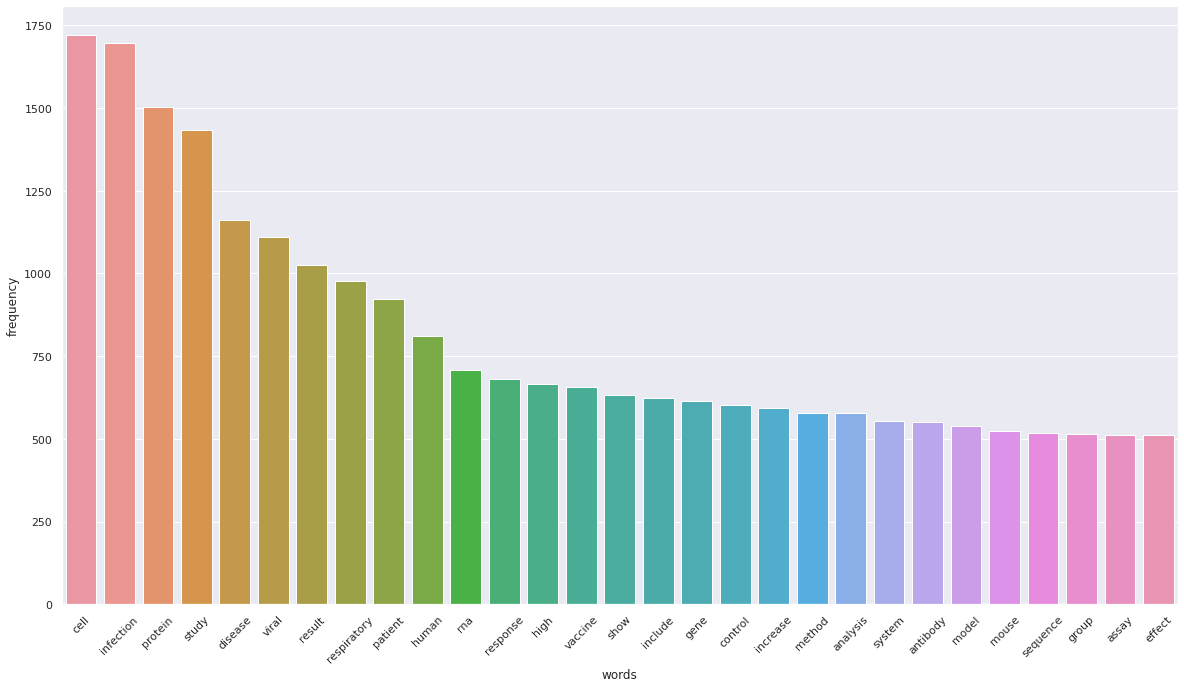

In [108]:
##Plot bar graph of words wrt frequency 
sns.set(style="whitegrid")
sns.set(rc={'figure.figsize':(20,11)})
ax = sns.barplot(x=word_freq_top30['words'][1:], y=word_freq_top30['frequency'])
#ax.set_xticklabels(ax.get_xticklabels(),rotation=45)
plt.xticks(rotation=45)

### Wordcloud

In [109]:
from wordcloud import WordCloud, STOPWORDS

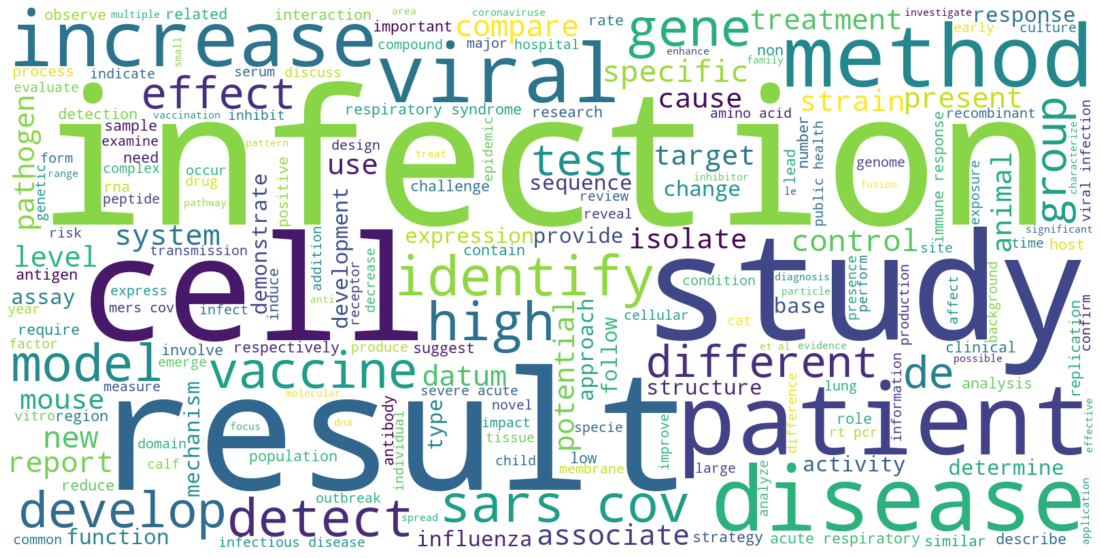

In [110]:
text = ' '.join(flatten(tokens_df.to_list())) ## text string of cleaned tokens 
stopwords = set(STOPWORDS) 
## add additional stopwwords based upon data, this is not final list, more words can added as per requiremet and data availability  
stopwords.update(["nan","find","show","conclusion","case","include","human","biorxib","day","total","author","funder",'virus','protein'])
wordcloud = WordCloud(stopwords=stopwords, background_color="white",width=1600,height=800).generate(text)

##Plotting
plt.figure(figsize=(20,10))
plt.axis("off")
# "bilinear" interpolation is used to make the displayed image appear more smoothly without overlapping of words  
# can change to some other interpolation technique to see changes like "hamming"
plt.imshow(wordcloud, interpolation="bilinear") 

plt.show()

## Preprocessing

### Extract all abbreviations and fullform from text

In [123]:
## This function will extract all abbreviations and respective full form used within the text.
## This function has further scope of improvement
import re
def extract_abbreviations(text):
    '''
    Input: Text string
    Output: Dictionary of abbreviation and respective full form
    '''
    abbr_fullform_dict=dict()
    abbr = re.findall('\(([A-Z]{2,})\)',text)
    #print(abbr)
    if len(abbr)<10:
        for i in abbr:
            span_abbr = re.search(i,text).span()
            len_full_form = str(span_abbr[1]-span_abbr[0])
            try:
                full_form = re.search('(\w+\s)'+'{'+len_full_form+'}'+'\('+i+'\)',text).group(0)
                if full_form[0].lower()!= i.lower()[0]:
                    full_form = ' '.join(full_form.split()[1:])
                if full_form.lower()[-1]!= i.lower()[-1]:
                    full_form = ' '.join(full_form.split()[:-1])
                full_form = full_form.replace('('+i+')','').strip()
                abbr_fullform_dict[i] = full_form
            except AttributeError:
                print("error")
                pass
    
        return abbr_fullform_dict    

In [ ]:
#corona_df["abbr_dict"]= pd.read_csv('/kaggle/input/abbreviations/abb.csv',names=['abb_dict'],header=None)

In [ ]:
## calling function for extractons of abbreviations and respective full form from text
corona_df["abbr_dict"] = corona_df["text_body"].progress_apply(lambda x:extract_abbreviations(x))

In [7]:
#Function for replacing abbreviations by its full form
import ast
import numpy as np
def remove_abbriviation(text,abbr_dict):
    try :
       
        #abbr_dict = ast.literal_eval(abbr_dict)
    
        for key,value in abbr_dict.items():
                #print(key,value)
                text = text.replace(key,value)
    except AttributeError:            
          pass
    return text    

### Remove Email id

In [8]:
#Function for removing emailids from text
def remove_email(text):
    if text:
        text = text.lower()
        text = re.sub('([a-zA-Z0-9_\-\.]+)@([a-zA-Z0-9_\-\.]+)\.([a-zA-Z]{2,5})','*email*',str(text))
    else:
        pass
    return text

### Remove weblink

In [9]:
# Function for removing website links from text
def remove_weblink(text):
    if text:
        text=text.lower()
        text = re.sub('(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})','link',str(text))
    else:
        pass
    return text

In [10]:
# Function for removing paper refrences from text e.g [19],[1a,2b] or [19,14,15]
def remove_refrence(text):
    if text:
        text=text.lower()
        text = re.sub('\[\d+(,\s{0,}\d+){0,}\]','',str(text))   
    else:
        pass
    return text

In [11]:
# Function for removing non ASCII charecters like 'Ϫ','ó','ü','©','µ','▲','→'
# This function check if charecter hex value in range [\x00,\x7F] (in decimal [0,127] i.e range of ASCII charecters) and replace if it occurs outside limit
def remove_ghost_char(text):
    if text:
        text = re.sub(r'[^\x00-\x7F]+',' ', str(text))
    else:
        pass
    
    return text

In [12]:
# This function remove all bracktes with data
def remove_brackets(text):
    if text:
        text = re.sub('(\(.*?\))|(\[.*?\])','',str(text))   
    else:
        pass
    return text                  

In [13]:
# Function for removing multiple spaces 
def remove_extra_spaces(text):
    if text:
        text = re.sub(r'( +)',' ', str(text))
    else: 
        pass
   
    return text

### Implemantation of Dask for fast processing and Better utilization of CPU
By using dask processing time can be decreased by ~10 times

In [14]:
def preprocess(df,dask_=False ,remove_abbr_=False,remove_email_=True,remove_weblink_=True,
               remove_refrence_=True,remove_brackets_=True,remove_ghost_char_=True,remove_extra_spaces_=True):
    start_time = time.time()
#     #series_text = corona_df['text_body']
#     series_abbr  = corona_df['abbr_dict']
#     _series = df["text_body"]
    
    if remove_abbr_: 
        print('Replacing abbreviations now!')
        _series = df.apply(lambda x: remove_abbriviation(x["text_body"],x["abbr_dict"]),axis=1)
    else:
        _series = df["text_body"]
                          
    if remove_email_: 
        print('Removing Email now!')
        if dask_:
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply( lambda x: remove_email(x),meta=('text_body', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
            _series = _series.apply(lambda x: remove_email(x))
    if remove_weblink_: 
        print('Removing weblink now!') 
        if dask_:                       
            _series = (dd
                               .from_pandas(df["text_body"], npartitions=4)
                               .apply(lambda x: remove_weblink(x),meta=('text_body', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
            _series = _series.apply(lambda x:  remove_weblink(x))                
    if remove_refrence_: 
        print('Removing refrences now!')
        if dask_:                    
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_refrence(x),meta=('text_body', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
             _series = _series.apply(lambda x:  remove_refrence(x))                   
                          
    if remove_brackets_: 
        print('Removing brackets now!')
        if dask_:                        
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_brackets(x),meta=('text_body', 'object'))
                               .compute(scheduler='processes')
                                )
        else :
            _series = _series.apply(lambda x:  remove_brackets(x))                 
    if remove_ghost_char_: 
        print('Removing bad charecters now!')
        if dask_:                       
            _series = (dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_ghost_char(x),meta=('text_body', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
            _series = _series.apply(lambda x: remove_ghost_char(x))                   
    if remove_extra_spaces_:
        print('Removing Extra spaces now!')
        if dask_:                       
            _series =(dd
                               .from_pandas(_series, npartitions=4)
                               .apply(lambda x: remove_extra_spaces(x),meta=('text_body', 'object'))
                               .compute(scheduler='processes')
                                )
        else:
             _series = _series.apply(lambda x: remove_extra_spaces(x))                 
    print ("completed preprocessing text in {:2f} minutes".format((time.time()-start_time)/60))
    
    return _series

In [15]:
# set "dask_ = True", to operate this function using Dask
# if good computing resources are available(cores>4 and RAM>16GB) then set it 'TRUE', don't try to run dask here, it will take all the RAM and freeze everything
corona_df["text_body"] = preprocess(corona_df,dask_= False)

Removing Email now!
Removing weblink now!
Removing refrences now!
Removing brackets now!
Removing bad charecters now!
Removing Extra spaces now!
completed preprocessing text in 7.146623 minutes


## Word Embeddings using BERT

### In this section we will create embeddings by using pretrainted transformer model BERT

Note: Word embeddings created by BERT takes lots of memory(>16GB), therefore instead of BERT embeddings, USE(Universal sentence encoder) embeddings are used for recommandation of text based upon query.  

https://github.com/jalammar/jalammar.github.io/blob/master/notebooks/bert/A_Visual_Notebook_to_Using_BERT_for_the_First_Time.ipynb

In [ ]:
## install required libraries for BERT
!pip install transformers
!wget -O scibert_uncased.tar https://s3-us-west-2.amazonaws.com/ai2-s2-research/scibert/huggingface_pytorch/scibert_scivocab_uncased.tar
!tar -xvf scibert_uncased.tar

In [ ]:
## import libraries
import torch
from transformers import BertTokenizer, BertModel

In [ ]:
# Let's load pretrained BERT model
model_version = 'scibert_scivocab_uncased'
do_lower_case = True
model = BertModel.from_pretrained(model_version)
tokenizer = BertTokenizer.from_pretrained(model_version,do_lower_case=do_lower_case)

In [ ]:
## Take 100 sentences to demonstrate BERT embeddings
sent_series= corona_df["text_body"].progress_apply(lambda x:re.split('\.',x))
sent= flatten(sent_series.to_list())[0:100]

### Tokenization

In [ ]:
#tokenize the sentences -- break them up into word and subwords in the format BERT is comfortable with
tokenized = df["sent"].progress_apply((lambda x: tokenizer.encode(x, add_special_tokens=True)))

### Padding
After tokenization, tokenized is a list of sentences -- each sentences is represented as a list of tokens. We want BERT to process our examples all at once (as one batch). It's just faster that way. For that reason, we need to pad all lists to the same size, so we can represent the input as one 2-d array, rather than a list of lists (of different lengths)

In [ ]:
from tqdm import tqdm
max_len = 0
for i in tqdm(tokenized.values):
    if len(i) > max_len:
        max_len = len(i)

padded= np.array([i + [0]*(max_len-len(i)) for i in tokenized.values])

In [ ]:
padded.shape

### Masking
If we directly send padded to BERT, that would slightly confuse it. We need to create another variable to tell it to ignore (mask) the padding we've added when it's processing its input. That's what attention_mask is:

In [ ]:
attention_mask = np.where(padded != 0, 1, 0)
attention_mask.shape

### Model #1: And Now, Deep Learning!
Now that we have our model and inputs ready, let's run our model

In [ ]:
## Uncomment for BERT encoddings (takes lots of memory, therefore USE is used for completing tasks)
# input_ids = torch.tensor(padded)  
# attention_mask = torch.tensor(attention_mask)

# with torch.no_grad():
#     last_hidden_states = model(input_ids, attention_mask=attention_mask)

In [ ]:
embeddings = last_hidden_states[0][:,0,:].numpy()

In [ ]:
embeddings.shape

## Embeddings for query

In [ ]:
query = 'incubate with the membranes'

In [ ]:
tok = torch.tensor(tokenizer.encode(query)).unsqueeze(0)

In [ ]:
with torch.no_grad():
    last_hidden_states = model(tok )

In [ ]:
embeddings_query = last_hidden_states[0][:,0,:].numpy()

In [ ]:
#embeddings_query.shape

## Word embeddings using USE
[https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html](https://ai.googleblog.com/2019/07/multilingual-universal-sentence-encoder.html)

The model is trained and optimized for greater-than-word length text, such as sentences, phrases or short paragraphs unlike BERT, which can only handles up to 512 characters. It is trained on a variety of data sources and a variety of tasks with the aim of dynamically accommodating a wide variety of natural language understanding tasks. The input is variable length English text and the output is a 128 dimensional vector. The universal-sentence-encoder model is trained with a deep averaging network (DAN) encoder.

In [16]:
!pip install "tensorflow_hub>=0.6.0"
!pip install "tensorflow>=2.0.0"

In [17]:
import tensorflow as tf
import tensorflow_hub as hub

## Load USE model
module_url = "https://tfhub.dev/google/nnlm-en-dim128/2"
embed = hub.KerasLayer(module_url)

### Tokenize documents by newline charecter

In [18]:
corona_df["text_body_sent"]= corona_df["text_body"].progress_apply(lambda x:re.split('\n',x))

In [19]:
import nltk
sent= nltk.flatten(corona_df["text_body_sent"].to_list())

In [20]:
df_sent = pd.DataFrame(columns=["sent","len"])
df_sent["sent"] = sent
df_sent["len"] = [len(str(i).split()) for i in sent]

In [21]:
df_sent['len'].describe()

count    1.168493e+06
mean     1.104201e+02
std      1.042199e+02
min      0.000000e+00
25%      4.100000e+01
50%      8.900000e+01
75%      1.500000e+02
max      5.633000e+03
Name: len, dtype: float64

In [22]:
## sentences those contains tokens more than 10
sent = [i for i in sent if len(str(i).split())>10] 

### Create embeddings(Deep-Learning)

In [23]:
# create embeddings for sentences
embeddings = embed(sent)

In [24]:
embeddings.shape

TensorShape([1052935, 128])

In [25]:
query = [" transmission of virus in community"]

In [26]:
## embedding for query
embeddings_query = embed(query)

In [27]:
embeddings_query.shape

TensorShape([1, 128])

### cosine similarity function
$$\begin{eqnarray}
cos(\pmb x, \pmb y) = \frac {\pmb x \cdot \pmb y}{||\pmb x|| \cdot ||\pmb y||} = \frac {\sum\limits_{i=0}^{n-1} x_i \cdot y_i}{\sqrt{\sum_{i=1}^{n-1} (x_i)^2} * \sqrt{\sum_{i=1}^{n-1} (y_i)^2} } 
\end{eqnarray}$$

In [28]:
#Calculate cosine similarity of query with all sentences
def cosine_similarity_func(embeddings,embeddings_query):
    '''
    Input:
         embeddings: array or tensor of all sentence embeddings (nX128 for n sentences)
         embeddings_query: array or tensor of query embedding (1X128)
    Output:
         cosine_similarity: cosine similarity of query with each sentence (nX1) 
    '''
    # x.y
    dot_product = np.sum(np.multiply(np.array(embeddings),np.array(embeddings_query)),axis=1)
    
    #||x||.||y||
    prod_sqrt_magnitude = np.multiply(np.sum(np.array(embeddings)**2,axis=1)**0.5, np.sum(np.array(embeddings_query)**2,axis=1)**0.5)
    
    #x.y/(||x||.||y||)
    cosine_similarity  = dot_product/prod_sqrt_magnitude
    return cosine_similarity

### Recommend text based upon cosine similarity 

In [29]:
# function for recommend text based upon query
def recommended_text(query,embeddings,sent,threshold_min=.95,threshold_max = 1):
    '''
    Input:
         query: list of queries
         embeddings: embeddings of all sentences
         sent:list all sentences
         threshold_min: lower limit of threshold for which sentence is supposed to be similar with query
         threshold_max: upper limit of threshold for which sentence is supposed to be similar with query
         
    Output:
          recommend_text: list of similar sentences with query
    '''
    recommend_text = []
    embeddings_query = embed(query) #create embedding for query
    
    cosine_similarity = cosine_similarity_func(embeddings,embeddings_query) # get cosine similarity with all sentences
    
    # standardize cosine similarity output, Range(0,1)
    standardize_cosine_simi  = (cosine_similarity-min(cosine_similarity))/(max(cosine_similarity)-min(cosine_similarity))
    
    #sort sent based upon cosine similarity score
    sent_prob = list(map(lambda x, y:(x,y), standardize_cosine_simi, sent)) 
    sent_prob.sort(key=lambda tup: tup[0], reverse=True)

    # select sentences by using upper and lower threshold
    for i,j in sent_prob:
        if (i >threshold_min) and (i<=threshold_max):
            recommend_text.append(j)
    return recommend_text  

# Tasks

## Task 1 (COVID-19 Open Research Dataset Challenge (CORD-19))
* **What is known about transmission, incubation, and environmental stability?**
   
 #### Task Details
****What is known about transmission, incubation, and environmental stability? What do we know about natural history, transmission, and diagnostics for the virus? What have we learned about infection prevention and control?****

Specifically, we want to know what the literature reports about:

* Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.
* Prevalence of asymptomatic shedding and transmission (e.g., particularly children).
* Seasonality of transmission.
* Physical science of the coronavirus (e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).
* Persistence and stability on a multitude of substrates and sources (e.g., nasal discharge, sputum, urine, fecal matter, blood).
* Persistence of virus on surfaces of different materials (e,g., copper, stainless steel, plastic).
* Natural history of the virus and shedding of it from an infected person
* Implementation of diagnostics and products to improve clinical processes
* Disease models, including animal models for infection, disease and transmission
* Tools and studies to monitor phenotypic change and potential adaptation of the virus
* Immune response and immunity
* Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings
* Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings
* Role of the environment in transmission

## Incubation period 
Range of incubation periods for the disease in humans (and how this varies across age and health status) and how long individuals are contagious, even after recovery.

In [36]:
query = ["range of incubation period of SARS"]

In [39]:
result = recommended_text(query,embeddings,sent,threshold_min=.95)

In [41]:
result

['statements of incubation period and sources of original incubation period data for',
 ' the incubation period of yellow fever is around 3-6 days. the incubation period of dengue fever is around 8-10 days.',
 ' the incubation period of lassa fever ranges from 3 to 21 days. symptoms of new world haemorrhagic fever typically develop over 7-14 days.',
 ' the challenges facing primary care providers are many: early diagnosis of avian or pandemic influenza; surge of cases when the pandemic arrives; shortages of antivirals; shortages of personal protective equipment; maintenance of social order; and provision of continuation of care despite the surge of cases .',
 ' the challenges facing primary care providers are many: early diagnosis of avian or pandemic influenza; surge of cases when the pandemic arrives; shortages of antivirals; shortages of personal protective equipment; maintenance of social order; and provision of continuation of care despite the surge of cases .',
 ' childhood are t

### Transmission

In [30]:
query = ["transmission of virus in community"]

In [33]:
result = recommended_text(query,embeddings,sent,threshold_min = .95)

In [34]:
result[0:30]     #top 30

[' cross transmission of respiratory viruses between small ruminants and bovines is a crucial aspect of disease control and epidemiology. presence and distribution of bovine major viral respiratory diseases in marmara region of turkey have been recently reported . present study aimed to demonstrate distribution of respiratory viruses in small ruminants living in small capacity family farms through antibody studies.',
 ' determination of the dynamics of disease transmission in geographically widespread areas global spread of foot-and-mouth disease; spread of newcastle disease virus in asia distinction between pathovars and nonpathovars pathogenic and nonpathogenic escherichia coli in petting zoos addressing hospital and institutional infectious disease problems',
 ' the generation of cytopathogenic bvdv within a calf persistently infected with noncytopathogenic virus re-suits in development of mucosal disease and death of the animal .',
 ' in turkey where approximately 30% of inhabitant

#### Role of environment in Transmission

In [42]:
# effect of environment factors on virus
# effect of weather on virus
# effect of climate on virus
#effect of environment factors on virus
query = ["effect of environment factors on virus"] 

In [43]:
result = recommended_text(query,embeddings,sent,threshold_min = .95)

In [45]:
result[0:50] #top 50 results 

['. although results vary in degree and direction, perceptions about the risk of disease and severity of infection that follow major pandemic threats may affect uptake of seasonal influenza vaccine',
 ' disease control efforts can also make it challenging to determine effects of climate change on disease. for instance, if climate change causes range shifts of parasites from tropical to temperate countries, this might result in an overall reduction, rather than increase, in human diseases because temperate countries often have superior health infrastructures . regardless of the outcome of climate change on diseases, integrating control efforts into projections should improve predictions of future disease risk for humans and wildlife. furthermore, given that control measures could obscure increases in transmission, incorporating control measures into models could reveal underlying increases in disease risk that might otherwise be missed.',
 ' environmental variables can affect responses 

### Seasonality of transmission

In [46]:
#intervals of virus
#seasonal outbreaks
query = ["seasonal outbreaks" ]

In [47]:
result = recommended_text(query,embeddings,sent,threshold_min =.93)

In [49]:
result

['recommendations on suitable virus strains for seasonal and pandemic influenza vaccines.',
 ' seasonal patterns were observed for hmpv, rhinovirus, enterovirus and influenza viruses with peak prevalence in late winter and spring . in addition, a seasonal pattern was detected for tuberculosis . no distinct seasonal patterns were observed for other microbes.',
 'not disperse low pathogenic avian influenza virus during autumn migration .',
 'the severity of seasonal influenza epidemics is unpredictable and influenced by the predominant circulating virus strains and level of immunity in the population . during peak community influenza activity, hospitals and emergency rooms may be overwhelmed by patients presenting with influenza-like illness and more severe disease , . illness attack rates may be higher among most age groups during pandemics than observed for seasonal influenza due to limited immunity among exposed populations . the re-emergence of highly pathogenic avian influenza a vir

## Physical science of the coronavirus
(e.g., charge distribution, adhesion to hydrophilic/phobic surfaces, environmental survival to inform decontamination efforts for affected areas and provide information about viral shedding).

In [50]:
query = ["adhesion to hydrophilic surfaces"]

In [51]:
result = recommended_text(query,embeddings,sent)

In [53]:
result

[' antiadhesive surfaces target microbial adhesion usually by the interaction of antagonist physicochemical properties. easy-clean surfaces that are hydrophobic repel bacteria better than glass-coated controls , while hydrophilic surfaces favour water sheeting and subsequent cleaning. similarly, polyethylene glycol coated surfaces promote a hydrophilic interaction against bacteria, preventing attachment . the use of diamond-like carbon films has already been tried for medical implanted devices such as joint prostheses and stents in order to repel microbial adhesion . despite being non-toxic and appealing, the lack of biocidal properties may turn discouraging a more generalized implementation of such easy-clean technologies.',
 ' antiadhesive surfaces target microbial adhesion usually by the interaction of antagonist physicochemical properties. easy-clean surfaces that are hydrophobic repel bacteria better than glass-coated controls , while hydrophilic surfaces favour water sheeting and

## Persistence of virus on surfaces of different materials 
(e,g., copper, stainless steel, plastic).

In [ ]:
query = ["persistence of virus on different inanimate surfaces"]

In [54]:
result =recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.97)

In [56]:
result

[' antiadhesive surfaces target microbial adhesion usually by the interaction of antagonist physicochemical properties. easy-clean surfaces that are hydrophobic repel bacteria better than glass-coated controls , while hydrophilic surfaces favour water sheeting and subsequent cleaning. similarly, polyethylene glycol coated surfaces promote a hydrophilic interaction against bacteria, preventing attachment . the use of diamond-like carbon films has already been tried for medical implanted devices such as joint prostheses and stents in order to repel microbial adhesion . despite being non-toxic and appealing, the lack of biocidal properties may turn discouraging a more generalized implementation of such easy-clean technologies.',
 ' antiadhesive surfaces target microbial adhesion usually by the interaction of antagonist physicochemical properties. easy-clean surfaces that are hydrophobic repel bacteria better than glass-coated controls , while hydrophilic surfaces favour water sheeting and

### Implementation of diagnostics and products to improve clinical processes

In [58]:
query = ['implementation of diagnostics and products to improve clinical processes']

In [59]:
result = recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.95)

In [62]:
result[:30] #top 50 results

[" therefore, china's advancements in research and development, technical and scientific capacity transferring can support african next generation of proactive scientists to develop more sensitive simplified diagnostic tools and reduce the costs of laboratory diagnosis and medical equipment. furthermore, research and development is needed in examining the biological mechanisms of stressors or risk factors exposure and health effects, assessing evidence-based mitigation or adaptation interventions and benefits . innovative solutions and breakthroughs in human-animal-environment fields would not only enable africa to meet its own growing needs, but also support integrating health systems, including strengthening the capacities of laboratory diagnostics and medical care, as well as establishing the china-africa platforms that could generate evidence-based low-cost, available and easy-to-use health packages and solutions for the reduction of public health burden.",
 ' 1. access to data and

### Physical science of the coronavirus

In [63]:
query = ['Physical science of the coronavirus']

In [64]:
result = recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.95)

In [66]:
result[:30]  # top 30 results

[' dr mourez is a virologist in the laboratory of microbiology, saint louis university hospital, paris. his research interests include the development of tests for the diagnosis of emerging respiratory viruses and the study of the circulation and molecular analysis of human respiratory viruses in pediatric and immunocompromised patients. ',
 ' the determination and quantification of concurrent viral excretion were performed using the diagnostic procedures available in the virology laboratory of the faculty of veterinary medicine -technical university of lisbon.',
 ' the ultrastructure study for the search for virus or viral particles conducted by the electron microscopy center of the national research council, university of bari, detected the presence of viral particles inside the cells of the nasal mucosa .',
 ' syntheses iii, vi, vii, and ix served to identify beyond doubt the history, identity and/or pathogenesis of important human pathogens . these include most notably the 1918 spa

### Implementation of diagnostics and products to improve clinical processes

In [67]:
query = ['implementation of diagnostics to improve clinical processes']

In [68]:
results = recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.95)

In [70]:
results[0:30] #top 30 results

[' 1. access to data and samples to enable and accelerate research, which would involve rapid sharing of epidemiological surveillance and clinical data to inform outbreak control strategies; incentives and platforms for open sharing and access to genomic sequencing data; access to specimen samples . 2. appropriate conduct of research, including improved ethical standards for research and development ; previous agreement about experimental protocols, such as trial design, to speed clinical trials when outbreaks strike; 80 access to clinical trial data, such as publication of negative and positive results; clear pathways for approval by stringent regulatory authorities and in countries of use; and building on and investing in research capacities in epidemicaff ected countries. 3. equitable access to the benefi ts of research, including priority, aff ordable access to newly developed health technologies for aff ected populations, including health workers; and ethical guidelines for ration

### Disease models, including animal models for infection, disease and transmission

In [71]:
query = ["desease models of transmission, infection and disease"]
#query = ["desease models of transmission"]

In [72]:
result = recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.95)

In [74]:
result

[" ivig kawasaki's disease prevention and treatment of viral disease in immunocompromised patients treatment of neonatal bacterial infection treatment and prevention of infections in burn patients anti-endotoxin antibodies for prevention of sepsis anti-idiotypic antibodies as vaccines",
 ' currently, organoids are used as models of different pathologies, including infectious diseases caused by viruses, bacteria, and protozoans . viral infection studies with organoid systems have included: norovirus, rotavirus, enteric adenovirus, and coronavirus invasion of intestinal organoids ; herpes simplex virus 1 and cytomegalovirus infection of cerebral organoids; zika virus infection of cerebral and human testicular organoids ; human airway organoids to model pathology and assess infectivity of emerging influenza , parainfluenza and respiratory syncytial viruses ; bk virus infection in human kidney tubuloids ; and human liver organoids to study infection with hepatitis b and its related tumorig

### Tools and studies to monitor phenotypic change and potential adaptation of the virus

In [75]:
query = ["tools and studies to monitor phenotypic change and potential adaptation of the virus"]

In [76]:
result = recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.95)

In [78]:
result[:30] # top 3 results

[' the concepts and methods of infectious disease epidemiology provide the tools to understand changes in temporal and spatial patterns of viral infections and the impact of interventions. traditional epidemiological methods provide powerful analytical approaches to measure associations between exposures and outcomes . recent technological advances enhance these methods and permit novel approaches to investigate the emergence, epidemiology, and transmission dynamics of viruses and associated diseases.',
 'the science of epidemiology has been developed over the last 200 years, using traditional methods to describe the distribution of diseases by person, place, and time. however, in the last several decades, a new set of technologies has become available, based on the methods of computer sciences, systems biology, and the extraordinary powers of the internet. technological and analytical advances can enhance traditional epidemiological methods to study the emergence, epidemiology, and tr

### Immune response and immunity

In [79]:
query = ["immune response and immunity"]

In [81]:
results = recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.90)

In [82]:
results

29

### Effectiveness of movement control strategies to prevent secondary transmission in health care and community settings

In [83]:
query = ["effectiveness of movement control strategies to prevent secondary transmission in health care and community settings"]

In [86]:
result = recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.95)

In [88]:
result[:30] #top 30 results

[' administrative controls are policies and procedures designed to prevent and reduce exposure and transmission of organisms within a health care facility. for administrative controls to be maximally effective, health care personnel at all levels must maintain a high level of awareness for potential threats in order to identify communicable or pathogenic infectious diseases. once identified, infection prevention interventions may be tailored to the specific pathogen. examples of policies and practices include mandating influenza vaccination among all health care personnel, requiring education of health care personnel around certain practices, and implementing syndromic screening in high-risk areas including the emergency departments, using isolation and barrier precautions and appropriate triage of potential cases .',
 ' implementation of infection control practices to prevent influenza transmission establishment of rapid and frequent communication within healthcare facilities and betw

### Effectiveness of personal protective equipment (PPE) and its usefulness to reduce risk of transmission in health care and community settings

In [89]:
query = ["effectiveness of personal protective equipment and its usefulness to reduce risk of transmission in health care and community settings"]

In [94]:
result = recommended_text(query,embeddings,sent,threshold_max=1,threshold_min=.95)

In [95]:
len(result)

659

In [96]:
result[0:30] #top 30 results

[' here, we will review how to evaluate different pathogens including emerging and reemerging infections in terms of severity of illness and epidemic potential and discuss strategies for their control within health care settings, using a framework based on four central pillars: elimination of potential exposure, implementation of administrative controls, facilitation of engineering and environmental controls, and protection of the health care worker and patient using hand hygiene and personal protective equipment . additional considerations are pre-epidemic vaccination and incremental costs and benefits of infection prevention interventions.',
 ' evaluation of cost-effective health care provision by technology-enabled frontline health workers, new models of integrated primary care for multiple risk factors and comorbidities, and impact of mobile phone and other information technologyemediated interventions on pointof-care diagnostics and quality of chronic continuous care exemplifies a